## Application of FCNs & GCNs to fmri movie data (camcan study)  

- Application of FCNs (Fully connected networks) and GCNs (Graphical Neural Networks - 1st order, 5th order, 8th order) to fmri data to classify time blocks of fmri data across subjects 
- Fmri data (camcan study) recorded while subjects watched a Hitchcock movie  

#### Glossary
- __TR__: Repetition time = 2.47 (time it takes to scan all slices)
- __fmri data__: 193 Timepoints (193 x 2.47 = 476 secs = 7.9 mins) x 400 ROIs 

    __python scripts__
- __util_funcs__ - contains functions used to load the fmri camcan data and to split the data into time blocks which the models try and classify 
- __model.py__ - contains the FCN and GCN models

### Contents

* [imports](#imports) 


* [1. Data](#data) 
* [2. Repeated_trials](#repeated_trials)
 - FCN, block duration = 6
* [3. Fmri - filtered & normalised](#filter_norm)
    * [3.1 Data loader](#data_loader)
    * [3.2. FCNs](#fcn)
    - Block durations of 6,8,
    * [3.3. GCNs](#gcn)
    - first order, 5th order neighbourhood
* [4. Fmri - filtered only](#filter)
    * [4.1 Data loader](#data_loader2)
    * [4.2 FCNs](#fcn2)
    - Block durations of 6,8,16
    * [4.3 GCNs](#gcn2)
    - first order, 5th order neighbourhood



#### Imports

In [23]:
import os
import sys
import math
import time
import datetime

import numpy as np
import pandas as pd
import scipy.io

import nibabel as nib
from scipy import sparse
from scipy.stats import spearmanr
from sklearn import preprocessing, metrics,manifold
from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
import itertools


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from util_funcs import *
from model import *

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='once')
#%load_ext autoreload #%autoreload #%reload_ext autoreload #import sys #reload(sys)

#imports
#pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html

#CPU
device = torch.device("cpu")
print(device)

cpu


In [24]:
check_it_updates()

NameError: name 'check_it_updates' is not defined

In [2]:
#Plot params
MEDIUM_SIZE = 14
BIGGER_SIZE = 17
plt.rc('font', size=MEDIUM_SIZE);
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1. Data - fmri data <a class="anchor" id="data"></a>

In [3]:
#fmri
root_pth = '/camcan/schaefer_parc/'
task_type = 'Rest'
fmri, subj_list = get_fmri_data(root_pth, task_type)
print(np.array(fmri).shape) #(193, 400)
print(len(subj_list)) #644 subjects
fmri_copy = fmri.copy()

(644, 261, 400)
644


##### Reduce num of time points

In [4]:
fmri = fmri[:,:193,:]
fmri.shape

(644, 193, 400)

In [6]:
#Adjacency matrix 
root_pth = '/camcan/schaefer_parc/'
adj_mat = get_rsfmri_adj_matrix(root_pth) #Should save this rather then recalculating 
#plot_corr_matrix(adj_mat)

ython3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1

In [11]:
np.min(adj_mat)

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.029650910855963202

In [7]:
#Adjacency matrix
adj_mat = Adjacency_matrix(adj_mat, n_neighbours = 8).get_adj_sp_torch_tensor()
adj_mat

tensor(indices=tensor([[  1,   2,   3,  ..., 396, 397, 398],
                       [  0,   0,   0,  ..., 399, 399, 399]]),
       values=tensor([0.3348, 0.4519, 0.3895,  ..., 0.4030, 0.5090, 0.3403]),
       size=(400, 400), nnz=4198, layout=torch.sparse_coo)

In [8]:
#Params
TR = 2.47
n_subjects = np.array(fmri).shape[0]
print(f'N subjects = {n_subjects}')
n_regions = np.array(fmri).shape[2] 
print(n_regions)

N subjects = 644
400


In [9]:
#Specify block duration
block_duration = 6 #8 #16 #6 8 -Factor of 192 
total_time = fmri.shape[1]
n_blocks = total_time // block_duration
n_labels = n_blocks
print(f'Number of blocks = {n_blocks}')
total_time = block_duration*n_blocks #Rounded number 
print(f'Total time = {total_time}')

Number of blocks = 32
Total time = 192


## 3. Filtered + Normalised Data <a class="anchor" id="filter_norm"></a>

In [17]:
def filter_fmri(fmri, standardize):  
    'filter fmri signal'
    
    #fmri
    fmri_filtered = []
    for subj in np.arange(0, fmri.shape[0]):
        fmri_subj = fmri[subj]
        filtered = nilearn.signal.clean(fmri_subj, sessions= None, detrend=True, 
                               standardize= False, confounds=None, low_pass= 0.1, 
                               high_pass= 0.01, t_r = TR, ensure_finite=False)
        fmri_filtered.append(filtered)
    
    return fmri_filtered

In [18]:
#Apply
standardize =  'zscore' #'psc', False
fmri_filtered = filter_fmri(fmri, standardize)
print(np.array(fmri_filtered).shape)

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:204: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not std < np.finfo(np.float).eps:
(644, 193, 400)


### 3.1  Dataloader (Train & Test sets) <a class="anchor" id="data_loader"></a>

In [19]:
#Split into train and test 
params = {'batch_size': 2, 
          'shuffle': True,
          'num_workers': 2}
test_size = 0.2
randomseed= 12345
rs = np.random.RandomState(randomseed)

#Training/Test indices
train_idx, test_idx = train_test_split(range(n_subjects), test_size = test_size, random_state=rs, shuffle=True)
print('Training on %d subjects, Testing on %d subjects' % (len(train_idx), len(test_idx)))

Training on 515 subjects, Testing on 129 subjects


In [20]:
#Train set
print(f'Block duration = {block_duration}')
fmri_data_train = [fmri_filtered[i] for i in train_idx] #Training subjects 
print(np.array(fmri_data_train).shape)
fmri_train = Fmri_dataset(fmri_data_train, TR, block_duration)
train_loader = DataLoader(fmri_train, collate_fn = fmri_samples_collate_fn, **params)

#Test set
fmri_data_test = [fmri_filtered[i] for i in test_idx]
print(np.array(fmri_data_test).shape)
fmri_test = Fmri_dataset(fmri_data_test, TR, block_duration)
test_loader = DataLoader(fmri_test, collate_fn=fmri_samples_collate_fn, **params)

Block duration = 6
(515, 193, 400)
(129, 193, 400)


In [21]:
## 2.1 Inspect Accuracy Results

, 10,  8,  7, 20, 26,  8,  2,
         2,  6, 31, 28, 31,  3,  6, 10,  1, 31,  3,  2,  1,  6,  0,  0,  3,  3,
         3,  8, 10,  6,  8, 10, 10,  5,  5,  5,  5,  8,  8, 11, 10,  5,  5, 10,
        30,  8,  5,  2,  9,  5,  6, 14, 25,  3])
PRED = tensor([ 0,  0, 10,  3,  4,  9,  1, 13,  5, 31,  9, 26,  5,  5, 28, 27, 10,  8,
        10,  5,  5, 10, 30, 10, 23, 31,  7, 10, 26,  5, 11, 25,  0,  1,  4,  3,
         4,  2,  6,  7,  8,  2, 13,  9, 10, 11,  7,  5,  8, 10, 10,  2,  7, 23,
        10,  8, 10,  8, 10,  5,  6, 10,  8, 31])
PRED = tensor([ 0,  1, 10,  3,  4,  8,  6,  7, 27,  8, 10, 31,  7, 31, 10,  5,  8, 23,
         8, 10, 26, 23,  2,  8,  8, 31,  5, 11, 23, 25, 31, 31])
Test Loss 0.046664 | Acc 0.151647
Model updated: Best-Acc = 0.151647

Epoch 9: 
Time Usage:1.531377 | Training Loss 0.047272 | Acc 0.133617
PRED = tensor([ 0,  0,  4,  4,  4, 15,  7, 25, 26,  5, 25,  9, 26, 26, 27, 26, 10, 15,
        26,  5, 27, 11, 30, 26, 24, 25, 23, 25, 26, 26, 25, 11,  0,  1,  2,  3,
      

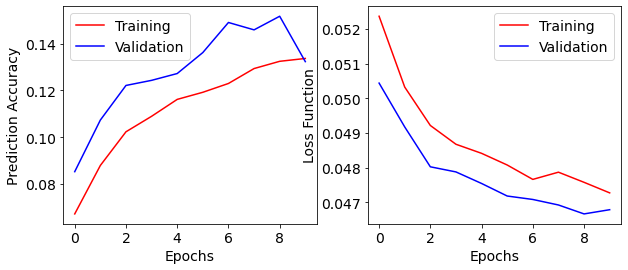

0.15164728682170542

In [22]:
#Block duration
print(f'Block duration = {block_duration}')

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=10
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

## 2.2 Repeated Trials <a class="anchor" id="repeated_trials"></a>

- FCN, block duraiton = 6

In [44]:
def run_fcn():
    
    #Block duration
    print(f'Block duration = {block_duration}')

    #Define model 
    model = FCN(n_regions, n_labels) #time points == x, regions == rows 
    model = model.to(device)
    print(model)
    print("{} paramters to be trained in the model\n".format(count_parameters(model)))
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss_func = nn.CrossEntropyLoss()
    num_epochs=10
    #adj_mat = 'a'

    best_acc = model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)
    
    return best_acc 

In [45]:
def get_repeated_results(n_repeats):
    'Get repeated results for fcn'
    
    dict_results = {}
    for i in np.arange(n_repeats):
        print('***************')
        print(f'Iteration = {i}')
        
        best_acc = run_fcn()
        dict_results[i] = [best_acc]
    
    df_results = pd.DataFrame(dict_results)
    
    return df_results.T

***************
Iteration = 0
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.600433 | Training Loss 0.052374 | Acc 0.068083
Test Loss 0.050488 | Acc 0.092539
Model updated: Best-Acc = 0.092539

Epoch 1: 
Time Usage:1.491942 | Training Loss 0.050426 | Acc 0.091869
Test Loss 0.049460 | Acc 0.106347
Model updated: Best-Acc = 0.106347

Epoch 2: 
Time Usage:1.465764 | Training Loss 0.049535 | Acc 0.101214
Test Loss 0.048136 | Acc 0.112888
Model updated: Best-Acc = 0.112888

Epoch 3: 
Time Usage:1.513552 | Training Loss 0.048692 | Acc 0.109709
Test Loss 0.047636 | Acc 0.126453
Model updated: Best-Acc = 0.126453

Epoch 4: 
Time Usage:1.530720 | Training Loss 0.0482

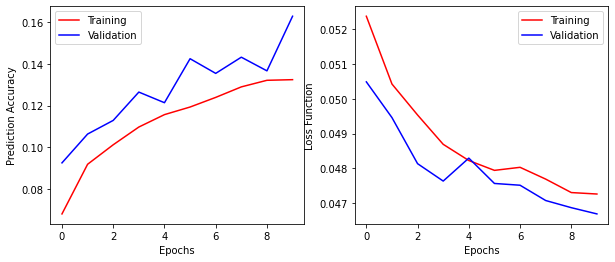

***************
Iteration = 1
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.610751 | Training Loss 0.052341 | Acc 0.068750
Test Loss 0.050586 | Acc 0.094477
Model updated: Best-Acc = 0.094477

Epoch 1: 
Time Usage:1.500118 | Training Loss 0.050149 | Acc 0.092597
Test Loss 0.048737 | Acc 0.109981
Model updated: Best-Acc = 0.109981

Epoch 2: 
Time Usage:1.564797 | Training Loss 0.049194 | Acc 0.102731
Test Loss 0.048228 | Acc 0.107558

Epoch 3: 
Time Usage:1.516621 | Training Loss 0.048681 | Acc 0.109223
Test Loss 0.047812 | Acc 0.132752
Model updated: Best-Acc = 0.132752

Epoch 4: 
Time Usage:1.541712 | Training Loss 0.048190 | Acc 0.118750
Test Loss 0.04724

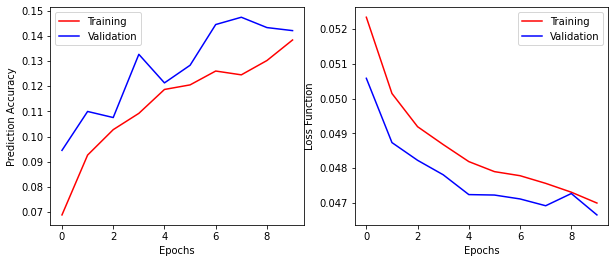

***************
Iteration = 2
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.537902 | Training Loss 0.052634 | Acc 0.064199
Test Loss 0.050598 | Acc 0.080184
Model updated: Best-Acc = 0.080184

Epoch 1: 
Time Usage:1.540041 | Training Loss 0.050420 | Acc 0.089138
Test Loss 0.048980 | Acc 0.111192
Model updated: Best-Acc = 0.111192

Epoch 2: 
Time Usage:1.516973 | Training Loss 0.049249 | Acc 0.108677
Test Loss 0.047833 | Acc 0.125484
Model updated: Best-Acc = 0.125484

Epoch 3: 
Time Usage:1.569709 | Training Loss 0.048520 | Acc 0.113289
Test Loss 0.047691 | Acc 0.128149
Model updated: Best-Acc = 0.128149

Epoch 4: 
Time Usage:1.583942 | Training Loss 0.0482

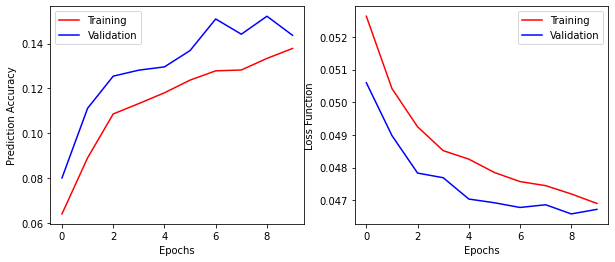

***************
Iteration = 3
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.476967 | Training Loss 0.052771 | Acc 0.067415
Test Loss 0.051465 | Acc 0.099322
Model updated: Best-Acc = 0.099322

Epoch 1: 
Time Usage:1.526057 | Training Loss 0.050402 | Acc 0.093689
Test Loss 0.048822 | Acc 0.103440
Model updated: Best-Acc = 0.103440

Epoch 2: 
Time Usage:1.624374 | Training Loss 0.049220 | Acc 0.103519
Test Loss 0.048142 | Acc 0.119913
Model updated: Best-Acc = 0.119913

Epoch 3: 
Time Usage:1.571501 | Training Loss 0.048494 | Acc 0.111833
Test Loss 0.047584 | Acc 0.122335
Model updated: Best-Acc = 0.122335

Epoch 4: 
Time Usage:1.727708 | Training Loss 0.0480

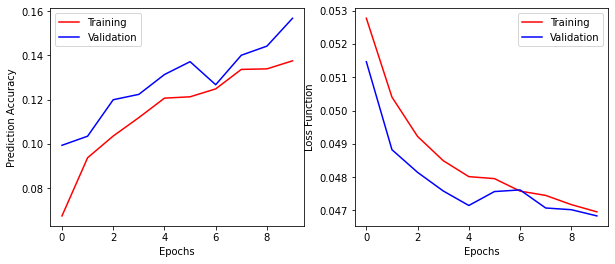

***************
Iteration = 4
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.566585 | Training Loss 0.052704 | Acc 0.062561
Test Loss 0.051229 | Acc 0.096899
Model updated: Best-Acc = 0.096899

Epoch 1: 
Time Usage:1.765100 | Training Loss 0.050431 | Acc 0.089927
Test Loss 0.049444 | Acc 0.113372
Model updated: Best-Acc = 0.113372

Epoch 2: 
Time Usage:1.553710 | Training Loss 0.049542 | Acc 0.100546
Test Loss 0.048038 | Acc 0.112161

Epoch 3: 
Time Usage:1.503516 | Training Loss 0.048695 | Acc 0.113592
Test Loss 0.047879 | Acc 0.119913
Model updated: Best-Acc = 0.119913

Epoch 4: 
Time Usage:1.489185 | Training Loss 0.048256 | Acc 0.119053
Test Loss 0.04876

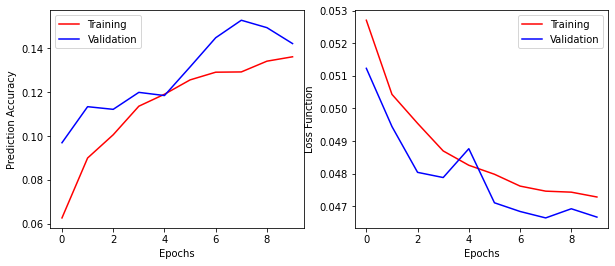

In [46]:
n_repeats = 5
df_results = get_repeated_results(n_repeats)

In [51]:
df_results.rename(columns = {0:f'Block duration = {block_duration}'})

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Block duration = 6
0,0.162791
1,0.147529
2,0.152132
3,0.156734
4,0.152859


### 3.2 FCN <a class="anchor" id="fcn"></a>

- Data = Filtered + Normalised

##### Block duration = 6*TR

Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=43, bias=True)
  )
)
56875 paramters to be trained in the model


Epoch 0: 
Time Usage:1.553898 | Training Loss 0.043069 | Acc 0.043667
Test Loss 0.042325 | Acc 0.065080
Model updated: Best-Acc = 0.065080

Epoch 1: 
Time Usage:1.590400 | Training Loss 0.041676 | Acc 0.063265
Test Loss 0.040805 | Acc 0.080224
Model updated: Best-Acc = 0.080224

Epoch 2: 
Time Usage:1.586936 | Training Loss 0.041180 | Acc 0.072432
Test Loss 0.040528 | Acc 0.084370
Model updated: Best-Acc = 0.084370

Epoch 3: 
Time Usage:1.541501 | Training Loss 0.040856 | Acc 0.077760
Test Loss 0.040479 | Acc 0.087435
Model updated: Best-Acc = 0.087435

Epoch 4: 
Time Usage:1.612553 | Training Loss 0.040449 | Acc 0.081599
Test Loss 0.

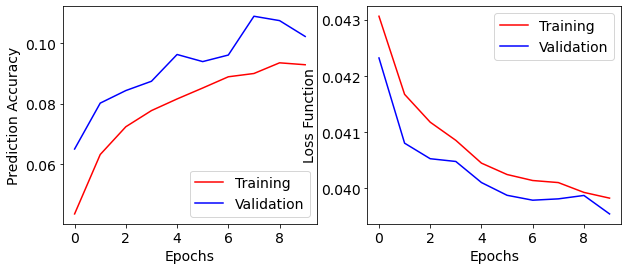

0.10888768703803858

In [24]:
#Block duration
print(f'Block duration = {block_duration}')

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=10
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 8*TR

cpu
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=24, bias=True)
  )
)
56248 paramters to be trained in the model


Epoch 0: 
Time Usage:2.089743 | Training Loss 0.047025 | Acc 0.332201
Test Loss 0.026241 | Acc 0.721899
Model updated: Best-Acc = 0.721899

Epoch 1: 
Time Usage:1.940850 | Training Loss 0.029784 | Acc 0.581068
Test Loss 0.018509 | Acc 0.802649
Model updated: Best-Acc = 0.802649

Epoch 2: 
Time Usage:2.073427 | Training Loss 0.024740 | Acc 0.653155
Test Loss 0.014441 | Acc 0.837855
Model updated: Best-Acc = 0.837855

Epoch 3: 
Time Usage:1.983021 | Training Loss 0.020553 | Acc 0.708657
Test Loss 0.016949 | Acc 0.796835

Epoch 4: 
Time Usage:2.076088 | Training Loss 0.019066 | Acc 0.736408
Test Loss 0.012225 | Acc 0.859496
Model updated: Best-Acc = 0.

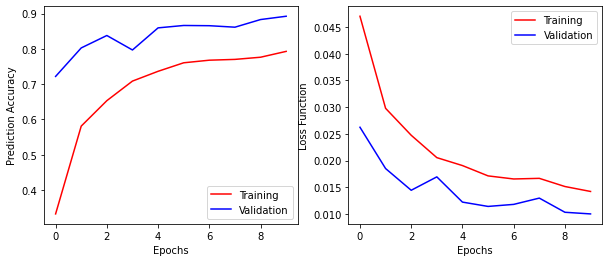

0.8924418604651163

In [40]:
#CPU
print(f'Block duration = {block_duration}')

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

Block duration = 16
cpu
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
)
55984 paramters to be trained in the model


Epoch 0: 
Time Usage:1.304915 | Training Loss 0.081308 | Acc 0.152791
Test Loss 0.076000 | Acc 0.206395
Model updated: Best-Acc = 0.206395

Epoch 1: 
Time Usage:1.266533 | Training Loss 0.076037 | Acc 0.203398
Test Loss 0.072592 | Acc 0.226744
Model updated: Best-Acc = 0.226744

Epoch 2: 
Time Usage:1.292430 | Training Loss 0.073971 | Acc 0.218568
Test Loss 0.071739 | Acc 0.246124
Model updated: Best-Acc = 0.246124

Epoch 3: 
Time Usage:1.306630 | Training Loss 0.072465 | Acc 0.229005
Test Loss 0.070681 | Acc 0.248062
Model updated: Best-Acc = 0.248062

Epoch 4: 
Time Usage:1.324821 | Training Loss 0.071961 | Acc 0.232646
Test Lo

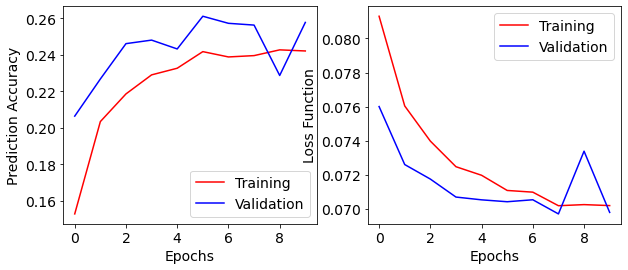

0.2611434108527132

In [14]:
print(f'Block duration = {block_duration}')

#CPU
device = torch.device("cpu")
print(device)

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=10
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

### 2. GCN <a class="anchor" id="gcn"></a>

##### Block duration = 6*TR
- __First Order__

Block duration = 6
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (6 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=43, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=43, bias=True)
  )
)
69614 paramters to be trained in the model


Epoch 0: 
Time Usage:316.793594 | Training Loss 0.043401 | Acc 0.031881
Test Loss 0.042899 | Acc 0.050658
Model updated: Best-Acc = 0.050658

Epoch 1: 
Time Usage:318.665421 | Training Loss 0.042559 | Acc 0.051208
Test Loss 0.042482 | Acc 0.053542
Model updated: Be

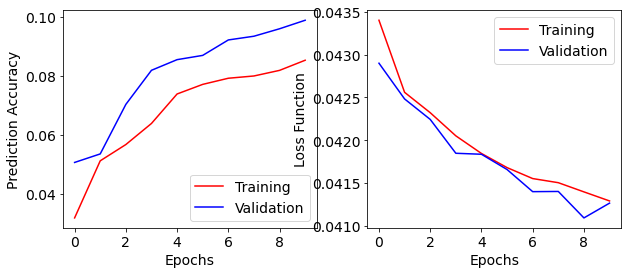

0.09879213989543897

In [29]:
from model import ChebNet

print(f'Block duration = {block_duration}')
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

#### GCN - expanding to k-th order neighborhood (connecting by k steps)

#### Block duration = 6

- Fifth Order K = 5

Block duration = 6
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(6, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=43, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=43, bias=True)
  )
)
80814 paramters to be trained in the model


Epoch 0: 
Time Usage:1336.549748 | Training Loss 0.043584 | Acc 0.034455
Test Loss 0.043057 | Acc 0.045610
Model updated: Best-Acc = 0.045610

Epoch 1: 
Time Usage:1327.818110 | Training Loss 0.043437 | Acc 0.033868
Test Loss 0.043053 | Acc 0.047052
Model updated: Best-Acc = 0.047052

E

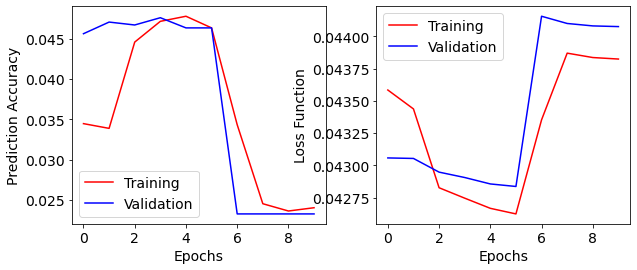

0.047593293672255274

In [18]:
#Model params 
k_order = 5
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

__K = 8__

In [11]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K= k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

Block duration = 6
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(6, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=43, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=43, bias=True)
  )
)
87534 paramters to be trained in the model



AttributeError: 'numpy.ndarray' object has no attribute '_indices'

##### Block duration = 16*TR
- First order

Block duration = 16
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (16 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=16, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)
59296 paramters to be trained in the model


Epoch 0: 
Time Usage:102.417664 | Training Loss 0.087129 | Acc 0.064320
Test Loss 0.087317 | Acc 0.062500
Model updated: Best-Acc = 0.062500

Epoch 1: 
Time Usage:101.573582 | Training Loss 0.086832 | Acc 0.062015
Test Loss 0.087314 | Acc 0.061531

Epoch 2: 
Time

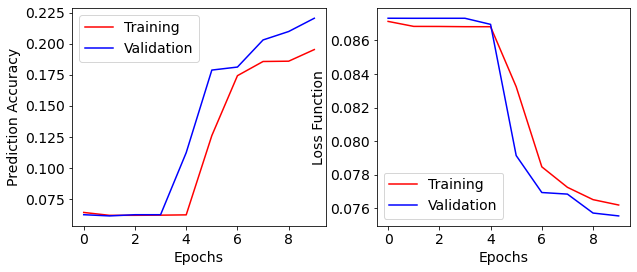

0.22044573643410853

In [15]:
from model import ChebNet

print(f'Block duration = {block_duration}')
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

#### GCN - expanding to k-th order neighborhood (connecting by k steps)

__K = 5__

Block duration = 16
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(16, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=16, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)
72096 paramters to be trained in the model


Epoch 0: 
Time Usage:338.398487 | Training Loss 0.083512 | Acc 0.112864
Test Loss 0.081673 | Acc 0.121124
Model updated: Best-Acc = 0.121124

Epoch 1: 
Time Usage:337.466105 | Training Loss 0.081350 | Acc 0.124150
Test Loss 0.081139 | Acc 0.123547
Model updated: Best-Acc = 0.123547

E

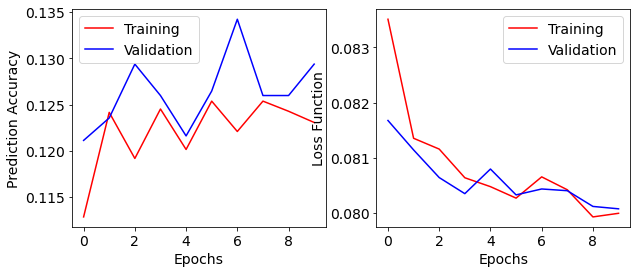

0.13420542635658914

In [16]:
#Model params 
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=5, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

__K = 8__

Block duration = 16
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(16, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=12, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=12, bias=True)
  )
)
78200 paramters to be trained in the model


Epoch 0: 
Time Usage:309.104297 | Training Loss 0.101765 | Acc 0.140291
Test Loss 0.086065 | Acc 0.299742
Model updated: Best-Acc = 0.299742

Epoch 1: 
Time Usage:305.677657 | Training Loss 0.081510 | Acc 0.313107
Test Loss 0.072405 | Acc 0.447674
Model updated: Best-Acc = 0.447674

E

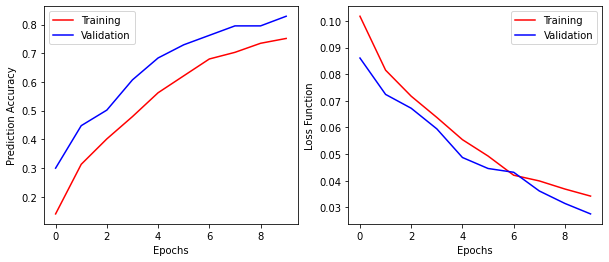

0.8288113695090439

In [65]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K= k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 8*TR
- First order

Block duration = 8
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (8 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
62192 paramters to be trained in the model


Epoch 0: 
Time Usage:136.866987 | Training Loss 0.064037 | Acc 0.084790
Test Loss 0.057415 | Acc 0.196705
Model updated: Best-Acc = 0.196705

Epoch 1: 
Time Usage:136.333657 | Training Loss 0.053554 | Acc 0.214887
Test Loss 0.048254 | Acc 0.322674
Model updated: Be

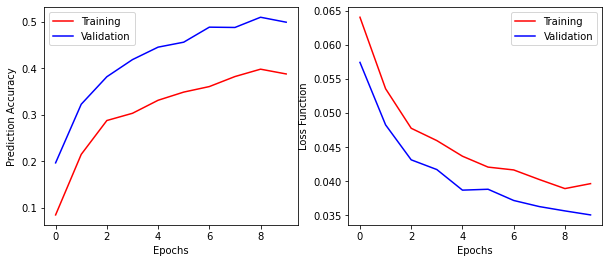

0.5096899224806202

In [72]:
from model import ChebNet

print(f'Block duration = {block_duration}')
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

#### GCN - expanding to k-th order neighborhood (connecting by k steps)

__K = 5__

Block duration = 8
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(8, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
73712 paramters to be trained in the model


Epoch 0: 
Time Usage:461.768672 | Training Loss 0.063813 | Acc 0.096359
Test Loss 0.056611 | Acc 0.254199
Model updated: Best-Acc = 0.254199

Epoch 1: 
Time Usage:462.501058 | Training Loss 0.053143 | Acc 0.233900
Test Loss 0.044483 | Acc 0.389858
Model updated: Best-Acc = 0.389858

Epo

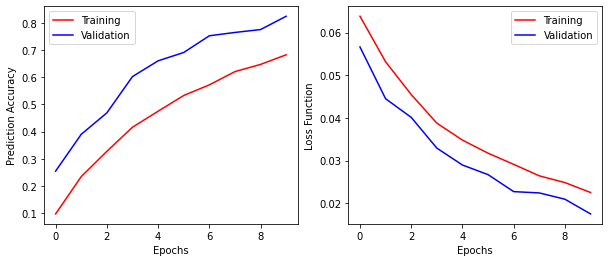

0.8252583979328165

In [73]:
#Model params 
k_order = 5
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

__K = 8__

Block duration = 8
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(8, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
80624 paramters to be trained in the model


Epoch 0: 
Time Usage:741.675057 | Training Loss 0.066621 | Acc 0.049272
Test Loss 0.065641 | Acc 0.086886
Model updated: Best-Acc = 0.086886

Epoch 1: 
Time Usage:747.862950 | Training Loss 0.061434 | Acc 0.142071
Test Loss 0.056878 | Acc 0.290052
Model updated: Best-Acc = 0.290052

Epo

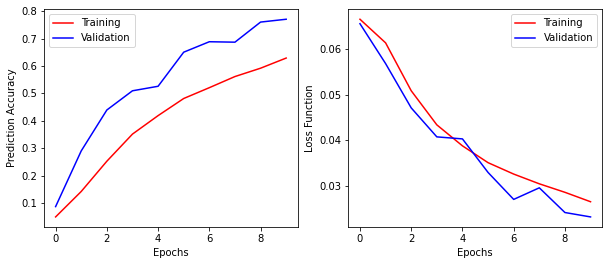

0.7703488372093024

In [74]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K= k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

## 4. Filtered + non-standardised data <a class="anchor" id="filter"></a>

In [24]:
def filter_fmri(fmri, standardize):  
    'filter fmri signal'
    
    #fmri
    fmri_filtered = []
    for subj in np.arange(0, fmri.shape[0]):
        fmri_subj = fmri[subj]
        filtered = nilearn.signal.clean(fmri_subj, sessions= None, detrend=True, 
                               standardize= False, confounds=None, low_pass= 0.1, 
                               high_pass= 0.01, t_r = TR, ensure_finite=False)
        fmri_filtered.append(filtered)
    
    return fmri_filtered

In [25]:
#Apply
standardize =  False #'psc', 'zscore'
fmri_filtered2 = filter_fmri(fmri, standardize)
print(np.array(fmri_filtered2).shape)

(644, 193, 400)


In [23]:
fmri.shape

(644, 193, 400)

### 4.1  Dataloader (Train & Test sets) <a class="anchor" id="data_loader2"></a>

In [21]:
#Split into train and test 
params = {'batch_size': 2, 
          'shuffle': True,
          'num_workers': 2}

test_size = 0.2
randomseed= 12345
rs = np.random.RandomState(randomseed)
#Training/Test indices
train_idx, test_idx = train_test_split(range(n_subjects), test_size = test_size, random_state=rs, shuffle=True)
print('Training on %d subjects, Testing on %d subjects' % (len(train_idx), len(test_idx)))

Training on 515 subjects, Testing on 129 subjects


In [22]:
#Train set
print(f'Block duration = {block_duration}')
fmri_data_train = [fmri_filtered2[i] for i in train_idx] #Training subjects 
print(np.array(fmri_data_train).shape)
fmri_train = Fmri_dataset(fmri_data_train, TR, block_duration)
train_loader = DataLoader(fmri_train, collate_fn = fmri_samples_collate_fn, **params)

#Test set
fmri_data_test = [fmri_filtered2[i] for i in test_idx]
print(np.array(fmri_data_test).shape)
fmri_test = Fmri_dataset(fmri_data_test, TR, block_duration)
test_loader = DataLoader(fmri_test, collate_fn=fmri_samples_collate_fn, **params)

Block duration = 6
(515, 261, 400)
(129, 261, 400)


## 4.2 FCN <a class="anchor" id="fcn2"></a>

##### Block duration = 6*TR

In [32]:
def run_fcn():
    
    #Block duration
    print(f'Block duration = {block_duration}')

    #Define model 
    model = FCN(n_regions, n_labels) #time points == x, regions == rows 
    model = model.to(device)
    print(model)
    print("{} paramters to be trained in the model\n".format(count_parameters(model)))
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss_func = nn.CrossEntropyLoss()
    num_epochs=10
    #adj_mat = 'a'

    best_acc = model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)
    
    return best_acc 

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
def get_repeated_results(n_repeats):
    'Get repeated results for fcn'
    
    dict_results = {}
    for i in np.arange(n_repeats):
        print('***************')
        print(f'Iteration = {i}')
        
        best_acc = run_fcn()
        dict_results[i] = [best_acc]
    
    df_results = pd.DataFrame(dict_results)
    
    return df_results.T

In [38]:
n_repeats = 5
df_results = get_repeated_results(n_repeats)

***************
Iteration = 0
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model



IndexError: Target 32 is out of bounds.

In [31]:
dict_results = {}
for i in np.arange(3):

    best_acc = 3.1*i
    dict_results[i] = [best_acc]

df_results = pd.DataFrame(dict_results)
df_results.T

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
0,0.0
1,3.1
2,6.2


In [ ]:
#Block duration
print(f'Block duration = {block_duration}')

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=10
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

Block duration = 16
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
)
55984 paramters to be trained in the model


Epoch 0: 
Time Usage:1.323977 | Training Loss 0.080751 | Acc 0.155461
Test Loss 0.075643 | Acc 0.184109
Model updated: Best-Acc = 0.184109

Epoch 1: 
Time Usage:1.250524 | Training Loss 0.075729 | Acc 0.195024
Test Loss 0.072756 | Acc 0.234496
Model updated: Best-Acc = 0.234496

Epoch 2: 
Time Usage:1.273951 | Training Loss 0.073959 | Acc 0.215898
Test Loss 0.071607 | Acc 0.245155
Model updated: Best-Acc = 0.245155

Epoch 3: 
Time Usage:1.286131 | Training Loss 0.072567 | Acc 0.230947
Test Loss 0.071610 | Acc 0.232074

Epoch 4: 
Time Usage:1.221655 | Training Loss 0.071748 | Acc 0.231675
Test Loss 0.070362 | Acc 0.250000
Model update

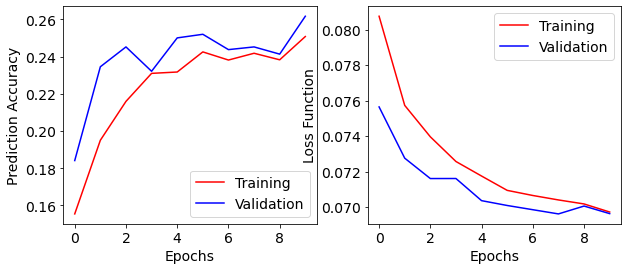

0.2616279069767442

In [21]:
#Block duration
print(f'Block duration = {block_duration}')

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=10
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

### 4.3. GCN <a class="anchor" id="gcn2"></a>
- First order

##### Block duration = 6*TR

In [ ]:
from model import ChebNet
print(f'Block duration = {block_duration}')

#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

##### Block duration = 8*TR

Block duration = 8
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (8 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
62192 paramters to be trained in the model


Epoch 0: 
Time Usage:136.669055 | Training Loss 0.064165 | Acc 0.080178
Test Loss 0.057848 | Acc 0.188953
Model updated: Best-Acc = 0.188953

Epoch 1: 
Time Usage:136.768747 | Training Loss 0.053608 | Acc 0.203883
Test Loss 0.047031 | Acc 0.354005
Model updated: Be

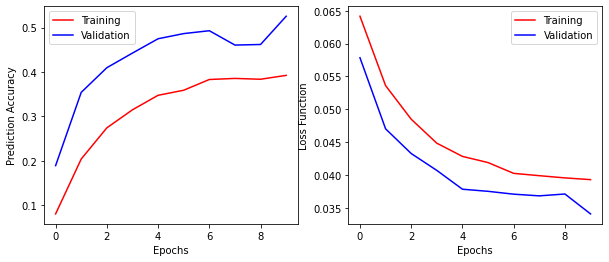

0.525516795865633

In [76]:
from model import ChebNet
print(f'Block duration = {block_duration}')

#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

Block duration = 16
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (16 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=16, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)
59296 paramters to be trained in the model


Epoch 0: 
Time Usage:102.530251 | Training Loss 0.087313 | Acc 0.065655
Test Loss 0.087321 | Acc 0.062500
Model updated: Best-Acc = 0.062500

Epoch 1: 
Time Usage:102.899635 | Training Loss 0.086824 | Acc 0.062743
Test Loss 0.087315 | Acc 0.062500

Epoch 2: 
Time

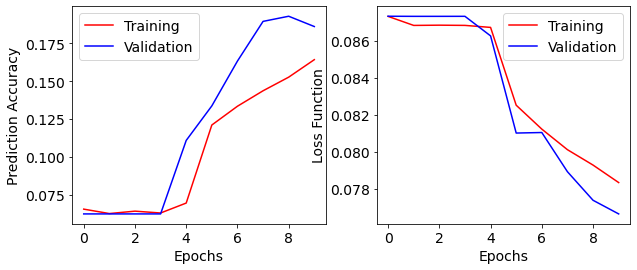

0.1928294573643411

In [22]:
from model import ChebNet
print(f'Block duration = {block_duration}')

#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

#### GCN - expanding to k-th order neighborhood (connecting by k steps)

##### Block duration = 6*TR

In [ ]:
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=5, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 8*TR

Block duration = 8
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(8, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
73712 paramters to be trained in the model


Epoch 0: 
Time Usage:462.142948 | Training Loss 0.066055 | Acc 0.053641
Test Loss 0.063942 | Acc 0.129522
Model updated: Best-Acc = 0.129522

Epoch 1: 
Time Usage:466.012141 | Training Loss 0.059438 | Acc 0.141181
Test Loss 0.053810 | Acc 0.273579
Model updated: Best-Acc = 0.273579

Epo

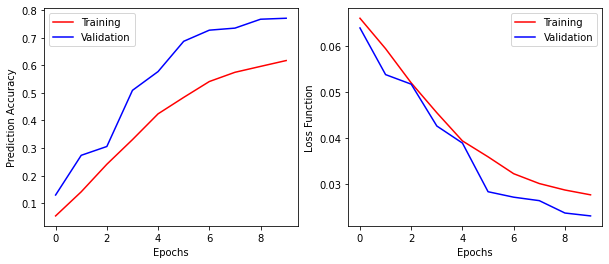

0.7709948320413437

In [77]:
#Model params 
k_order = 5
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(16, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=16, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)
72096 paramters to be trained in the model


Epoch 0: 
Time Usage:338.331022 | Training Loss 0.085189 | Acc 0.091262
Test Loss 0.080880 | Acc 0.132267
Model updated: Best-Acc = 0.132267

Epoch 1: 
Time Usage:339.163326 | Training Loss 0.082012 | Acc 0.126820
Test Loss 0.079388 | Acc 0.153101
Model updated: Best-Acc = 0.153101

Epoch 2: 
Time Usage:

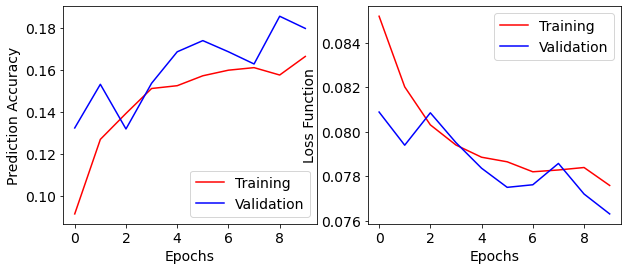

0.18556201550387597

In [23]:
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=5, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### K = 8

##### Block duration = 6*TR

In [ ]:
#Model params 
k_order = 6
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 8*TR

Block duration = 8
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(8, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
80624 paramters to be trained in the model


Epoch 0: 
Time Usage:739.784038 | Training Loss 0.066139 | Acc 0.055016
Test Loss 0.059645 | Acc 0.104651
Model updated: Best-Acc = 0.104651

Epoch 1: 
Time Usage:741.762217 | Training Loss 0.058464 | Acc 0.144337
Test Loss 0.053052 | Acc 0.282300
Model updated: Best-Acc = 0.282300

Epo

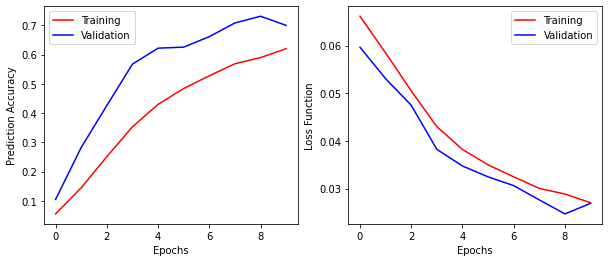

0.7309431524547804

In [78]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

Block duration = 16
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(16, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=16, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)
79776 paramters to be trained in the model


Epoch 0: 
Time Usage:536.545885 | Training Loss 0.087716 | Acc 0.075121
Test Loss 0.082718 | Acc 0.129360
Model updated: Best-Acc = 0.129360

Epoch 1: 
Time Usage:539.073224 | Training Loss 0.082745 | Acc 0.117718
Test Loss 0.081606 | Acc 0.117733

Epoch 2: 
Time Usage:536.681516 | Tr

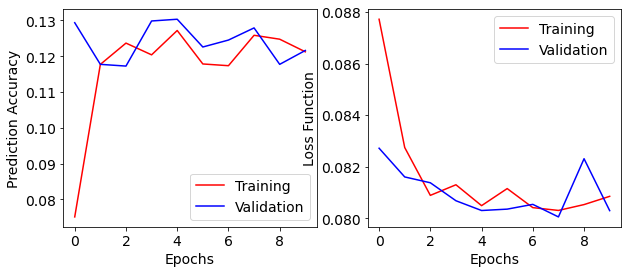

0.1303294573643411

In [24]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)